# Анализ бизнес-показателей

**Описание исследования:**

**Заказчик** - развлекательное приложение Procrastinate Pro+. 
**Задача** - разобраться в причинах убытков от рекламы.
**Цель** - выявить причины неэффективности, дать рекомендации


**Описание данных**
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день
    
**Таким образом, исследование пройдет в 7 этапов**
- Обзор данных
- Подготовка данных
- Подготовка функций
- Исследовательский анализ данных
- Маркетинговый анализ данных
- Оценка окупаемости рекламы
- Вывод

## Обзор данных

In [33]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore') 

In [34]:
# Загружаем датасеты
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [35]:
# Изучим таблицу visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [36]:
# Изучим таблицу orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [37]:
# Изучим таблицу costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [38]:
# Проверим наличие дубликатов в таблмце visits
visits.duplicated().sum()

0

In [39]:
# Проверим наличие дубликатов в таблмце orders
orders.duplicated().sum()

0

In [40]:
# Проверим наличие дубликатов в таблмце costs
costs.duplicated().sum()

0

**Вывод:**
- Во всех датасетах пропусков нет
- Во всех датасетах названия столбцов необходимо привести к одному виду
- Необходимо изменить тип данных на datetime в visits['Session Start'], visits['Session End'], orders['Event Dt'], costs['dt']
- Во всех датасетах дубликатов нет

## Подготовка данных

### Переименование колонок

In [41]:
# Переведем названия в строчные буквы
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [42]:
# Заменим пробелы на нижнее подчеркивание
visits = visits.rename(columns = {'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})
orders = orders.rename(columns = {'user id': 'user_id', 'event dt': 'event_dt'})

### Изменение типа данных на datetime

In [43]:
# Изменим тип данных на datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## Подготовка функций

In [44]:
# Зададим функцию для расчета LTV, ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [45]:
# Зададим функцию для рассчета rate_retention

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [46]:
# Зададим функцию для рассчета конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [47]:
# Зададим функцию для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [48]:
# зададим функцию для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1, color=sns.color_palette('Set3', 10), xlabel='Лайфтайм', title='LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, color=sns.color_palette('Set3', 10), xlabel='Дата привлечения', title='Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3, color=sns.color_palette('Set3', 10), xlabel='Дата привлечения',
    title='Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4, color=sns.color_palette('Set3', 10), xlabel='Лайфтайм', title='ROI')
    plt.axhline(y=1, linestyle='--', label='Уровень окупаемости')


    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(color=sns.color_palette('Set3', 10), grid=True, ax=ax5, xlabel='Дата привлечения', title='Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.axhline(y=1, linestyle='--', label='Уровень окупаемости')


    plt.tight_layout()
    plt.show() 


In [49]:
# зададим функцию для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [50]:
# зададим функцию для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1, color=sns.color_palette('Set3', 10), xlabel='Лайфтайм', title='Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, color=sns.color_palette('Set3', 10), ax=ax2, xlabel='Дата привлечения', title='Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [51]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1, color=sns.color_palette('Set3', 10), xlabel='Лайфтайм', title='Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2, color=sns.color_palette('Set3', 10), xlabel='Лайфтайм', title='Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3, color=sns.color_palette('Set3', 10), xlabel='Дата привлечения', title='Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4, color=sns.color_palette('Set3', 10), xlabel='Дата привлечения', title='Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 


## Исследовательский анализ данных

### Создание пользовательских профилей

In [52]:
# применим функцию get_profiles для нахождения пользовательских профилей, сохраним результат в новую переменную profiles
profiles = get_profiles(visits, orders, costs)

In [53]:
# минимальная дата привлечения пользователей
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [54]:
# максимальная дата привлечения пользователей
profiles['dt'].max()

datetime.date(2019, 10, 27)

### Изучение регионов

In [55]:
# Найдем количество пользователей из разных стран и процент платящих
region = profiles.groupby('region').agg({'user_id' : 'nunique', 'payer' : 'mean' }).rename(columns={'user_id':'count'})
region['% payer'] = region['payer']*100
region.sort_values(by='% payer', ascending=False)

,count,payer,% payer
region,,,
United States,100002,0.069019,6.901862
Germany,14981,0.041119,4.111875
UK,17575,0.039829,3.982930
France,17450,0.037994,3.799427


### Изучение устройств

In [56]:
# Найдем количество пользователей, заходящих с разных устройтств и процент платящих
device = profiles.groupby('device').agg({'user_id' : 'nunique', 'payer' : 'mean'}).rename(columns={'user_id':'count'})
device['% payer'] = device['payer']*100
device.sort_values(by='% payer', ascending=False)

,count,payer,% payer
device,,,
Mac,30042,0.063644,6.364423
iPhone,54479,0.062079,6.207897
Android,35032,0.058518,5.851793
PC,30455,0.050468,5.046790


### Изучение каналов привлечения

In [57]:
# Найдем количество пользователей, привлеченных с разных каналов и процент платящих
channel = profiles.groupby('channel').agg({'user_id' : 'nunique', 'payer' : 'mean' }).rename(columns={'user_id':'count'})
channel['% payer'] = channel['payer']*100
channel.sort_values(by='% payer', ascending=False)

,count,payer,% payer
channel,,,
FaceBoom,29144,0.122049,12.204914
AdNonSense,3880,0.113402,11.340206
lambdaMediaAds,2149,0.104700,10.469986
TipTop,19561,0.096007,9.600736
RocketSuperAds,4448,0.079137,7.913669
WahooNetBanner,8553,0.052964,5.296387
YRabbit,4312,0.038265,3.826531
MediaTornado,4364,0.035747,3.574702
LeapBob,8553,0.030633,3.063253


### Промежуточные выводы

- Минимальная дата привлечения пользователей - 01.05.2019, максимальная - 27.10.2019
- Пользователи приложения приходят из США, Великобритании, Франции и Германии. Больше всего платящих приходится на США (~ 6% от всех пользователей в регионе)
- Клиенты приложения пользуются девайсами iPhone, Android, Mac, PC. Больше всего платящих приходится на iPhone (~ 6%)
- Пользователи приходят из 11 источников привлечения. Топ-3 среди количества привлеченных платящих пользователей - FaceBoom (~ 12%), AdNonSense (~ 11%), lambdaMediaAds (~ 10%). 

## Маркетинговый анализ

### Расходы на рекламу

In [58]:
# Посчитаем общую сумму расходов на маркетинг
costs['costs'].sum()

105497.30000000002

In [59]:
# Посмотрим как расходы распределены по каналам привлечения
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

In [60]:
# Посмотрим как расходы распределены по месяцам
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.groupby('month')['costs'].sum().sort_values(ascending=False)

month
9     22441.340
10    20882.415
8     20657.870
7     16447.060
6     15090.045
5      9978.570
Name: costs, dtype: float64

In [61]:
# Посмотрим как расходы распределены по месяцам в разбивке по каналам
costs.pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')

month,5,6,7,8,9,10
channel,,,,,,
AdNonSense,1169.70,538.650,504.00,579.60,581.70,537.600
FaceBoom,3524.40,5501.100,5294.30,6274.40,6114.90,5736.500
LeapBob,140.28,314.580,313.53,369.81,343.98,315.420
MediaTornado,238.56,138.000,138.48,154.56,144.72,140.160
OppleCreativeMedia,169.75,370.000,366.50,439.25,427.75,378.000
RocketSuperAds,577.98,325.715,252.07,253.11,218.40,205.725
TipTop,2981.00,6675.600,8410.20,11202.00,13232.50,12250.000
WahooNetBanner,418.80,921.000,851.40,1040.40,977.40,942.000
YRabbit,299.70,106.200,97.38,124.74,152.79,163.410


<Figure size 720x504 with 0 Axes>

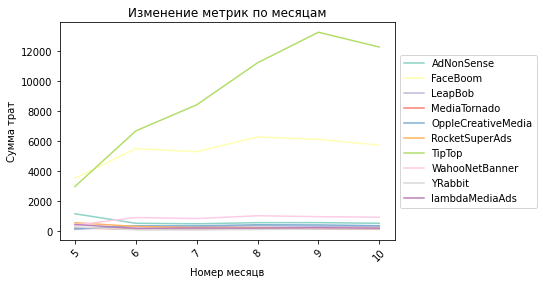

In [65]:
# Визуализируем изменение метрик по месяцам

plt.figure(figsize=(10, 7))
ax = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot.line(color=sns.color_palette('Set3', 10), 
                                               rot=45, 
                                               xlabel='Номер месяцв', 
                                               ylabel='Сумма трат', 
                                               title='Изменение метрик по месяцам')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [63]:
# Отфильтруем органических пользователей
profiles = profiles.query('channel != "organic"')

<Figure size 504x360 with 0 Axes>

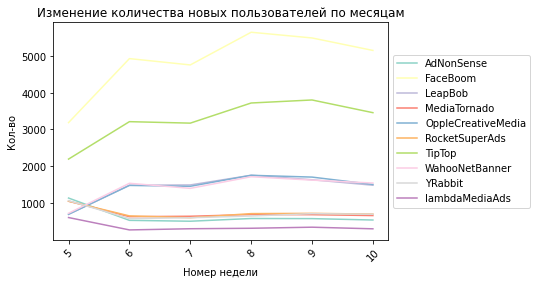

In [69]:
# Дополнительно визуализируем изменение количества новых пользователей по месяцам


plt.figure(figsize=(7, 5))
ax = profiles.pivot_table(index='month', columns='channel', values='user_id', aggfunc='nunique').plot.line(color=sns.color_palette('Set3', 10), 
                                               rot=45, 
                                               xlabel='Номер недели', 
                                               ylabel='Кол-во', 
                                               title='Изменение количества новых пользователей по месяцам')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Расчет CAC

In [151]:
# Рассчитаем средний САС для всего проекта
profiles['acquisition_cost'].mean()

1.1274813239427588

In [152]:
# Рассчитаем среддний САС для каждого источника
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
Name: acquisition_cost, dtype: float64

### Промежуточные выводы

- Всего было потрачено на рекламу - около 105497 ден. ед
- Топ-3 самых дорогих источников привлечения пользователей - TipTop (54751.30), FaceBoom (32445.60), WahooNetBanner (5151.00), топ-3 самых недорогих источника - organic (0), LeapBob (0.210172), MediaTornado (0.218717)
- Больше всего средств на маркетинг было потрачено в последние месяца: 8, 9, 10. В целом, наблюдается тенденция роста потраченных средств. Также, судя по графикам, вложения в TipTop с каждым месяцем увеличиваются, но приносят меньше пользователей, чем AddNonSence, в который вкладывались меньше.
- В среднем, один новый пользователь обошелся компании в 1,1 ден. ед.
- Дороже всего обошлись пользователи с источников - TipTop (2.799003), FaceBoom (1.113286), AdNonSense (1.008054), дешевле всего - MediaTornado (0.218717), LeapBob (0.210172), organic (0), это также отражается на количестве потраченных средств в целом.

## Анализ окупаемости рекламы

### Общая окупаемость рекламы

In [153]:
# Посчитаем общий LTV, CAC, ROI с помощью функции get_ltv()
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14)

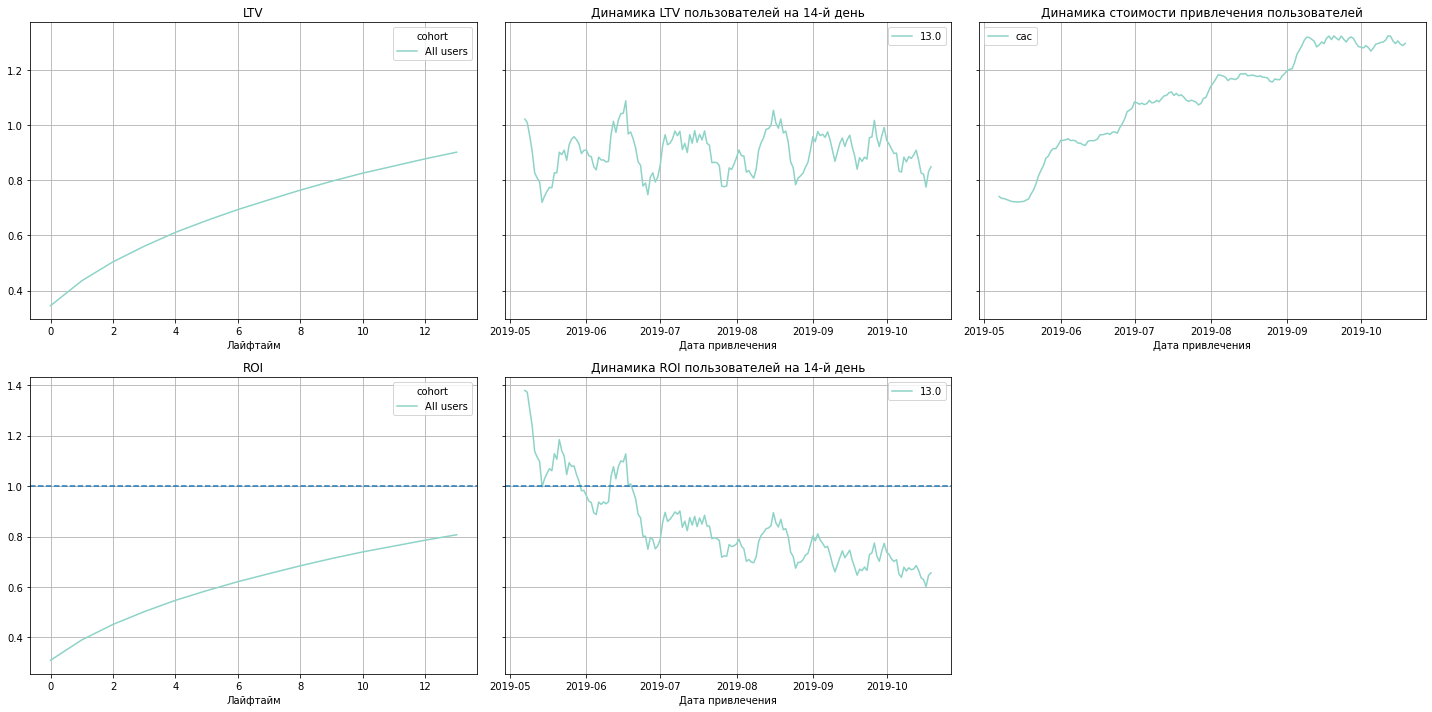

In [154]:
# Построим график LTV, ROI

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)


### Окупаемость рекламы с разбивкой по рекламным каналам

In [155]:
# Посчитаем LTV, CAC, ROI по каналам с помощью функции get_ltv(), укажем dimensions
channel_raw, ltv_channel, ltv_channel_hist, roi_channel, roi_channel_hist = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

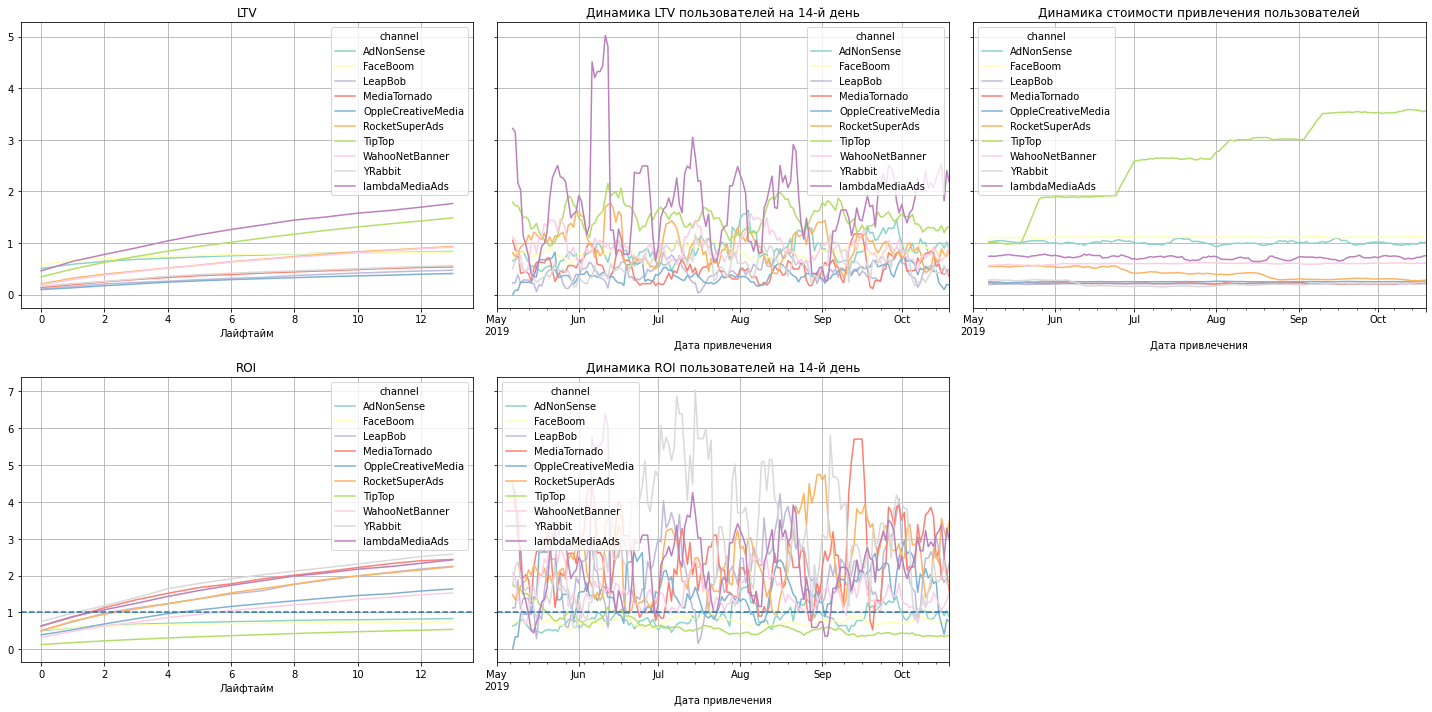

In [156]:
# Построим графики
plot_ltv_roi(ltv_channel, ltv_channel_hist, roi_channel, roi_channel_hist, 14)

### Окупаемость рекламы с разбивкой по устройствам

In [157]:
# Посчитаем LTV, CAC, ROI по девайсам с помощью функции get_ltv(), укажем dimensions
device_raw, ltv_device, ltv_device_hist, roi_device, roi_device_hist = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

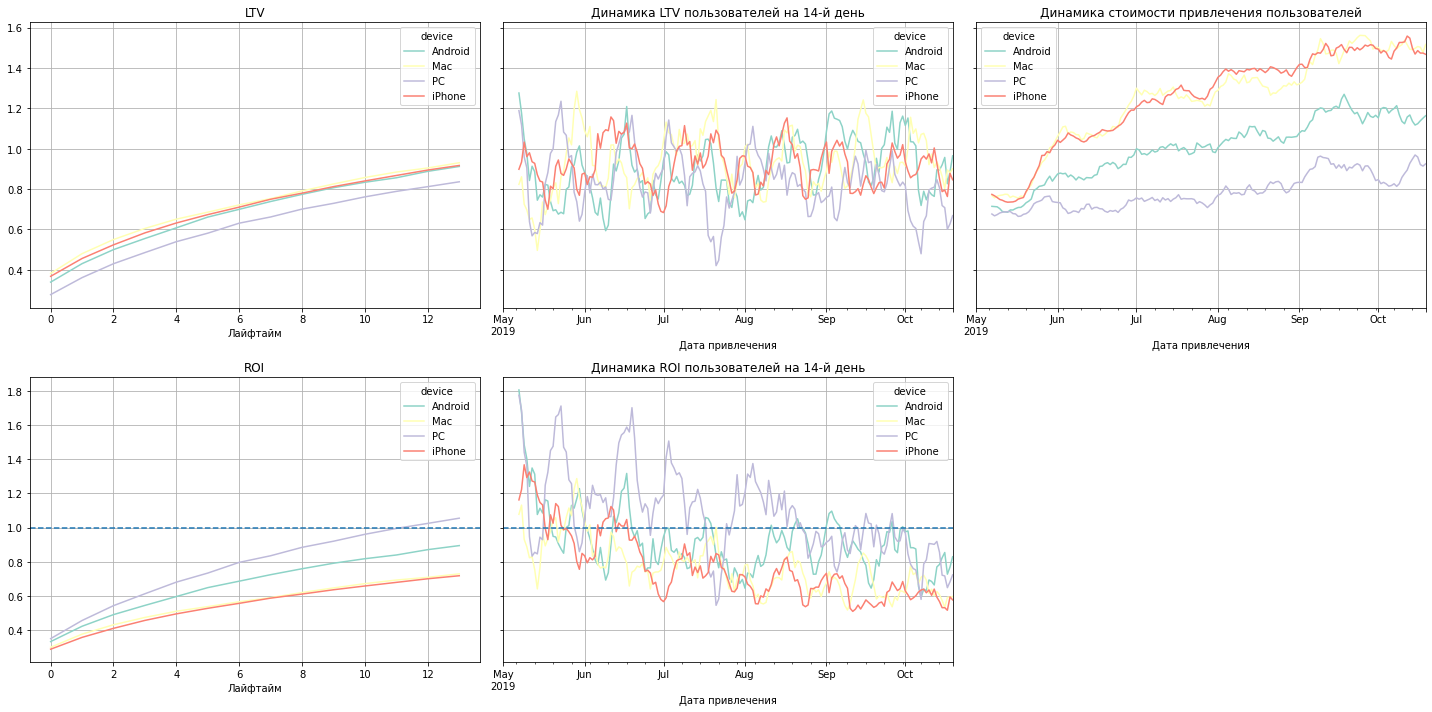

In [158]:
# Построим графики
plot_ltv_roi(ltv_device, ltv_device_hist, roi_device, roi_device_hist, 14)

### Окупаемость рекламы с разбивкой по странам

In [159]:
# Посчитаем LTV, CAC, ROI по странам с помощью функции get_ltv(), укажем dimensions
region_raw, ltv_region, ltv_region_hist, roi_region, roi_region_hist = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

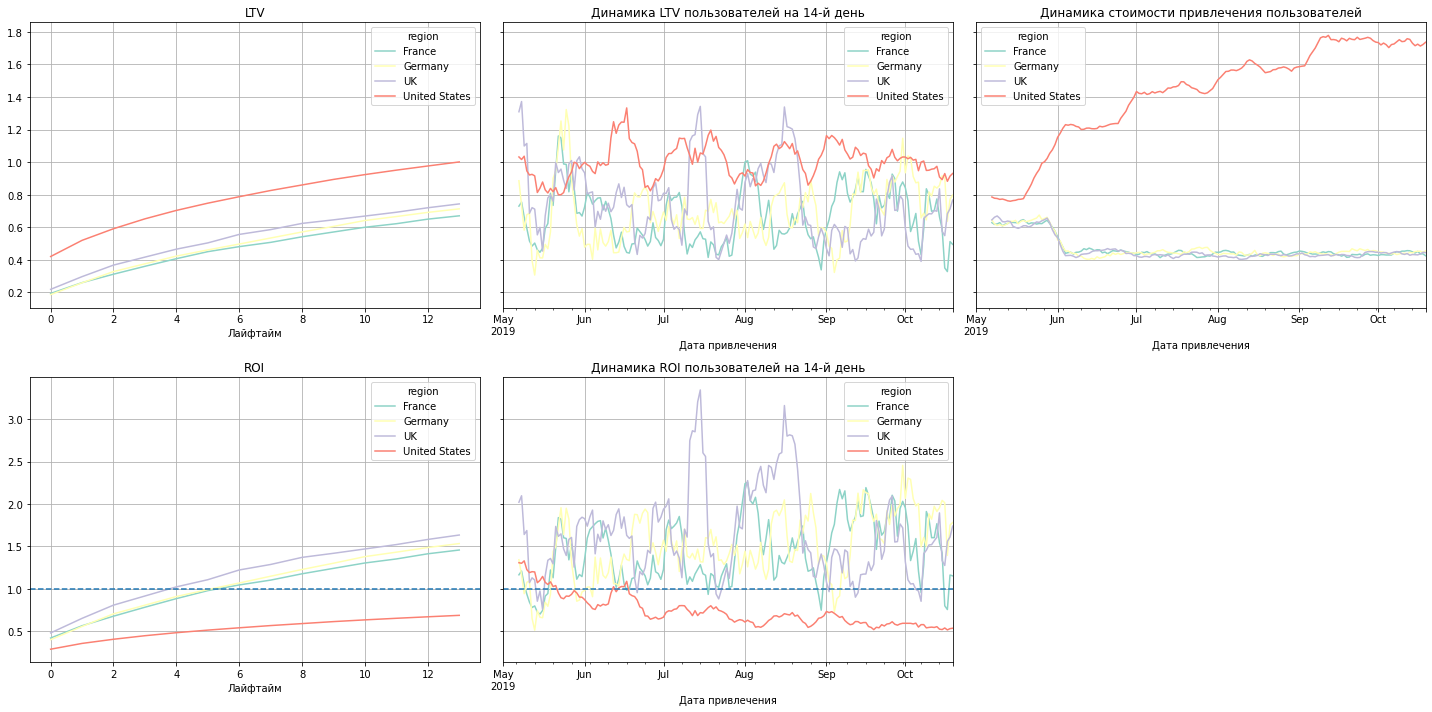

In [160]:
# Построим графики
plot_ltv_roi(ltv_region, ltv_region_hist, roi_region, roi_region_hist, 14)

### Промежуточные выводы
**В общем:**
- LTV к концу лайфтайма почти достигает 0,70.
- Пик LTV на 14 день приходится на июнь. 
- Стоимость привлечения неуклонно растет, резкий скачок приходится на июнь.
- Однако траты на рекламу к концу лайфтайма едва окупаются.
- Динамика окупаемости на 14 день показывает ежемесячный спад, резкий скачок вниз также приходится на июнь.
- Вероятно, прилив "дешевой" аудитории в первые месяцы рекламы мотивировал руководство больше вкладываться в маркетинг, однако дальнешая реклама показывала уже не такие результаты, а расходы на нее увеличивались. 

**В разбивке по рекламным каналам:**
- Выше всего показывают LTV LambdaMediaAds, TipTop
- На графике динамики LTV выделяется LambdaMediaAds с наиболее высокими, однако не такими стабильными показателями
- Наиболее высокая цена за пользователя приходится на канал TipTop, остальные каналы примерно на одном и том же уровне
- Из-за этого, траты на TipTop не окупаются, также за пределами черты находятся каналы FaceBoom и AddNonSence, выше всего окупаемость у YRabbit, MediaTornado, LambdaMediaAds

**В разбивке по устройствам:**
- Выше всего LTV показывают пользователи с Mac, iPhone, значительно отстает PC
- Динамика LTV менее однородная, визуально результаты ниже всего у PC, резкий скачок приходится на июнь.
- Тем не менее стоимость привлечения пользователей с Mac и iPhone выше
- Отсюда, ROI не достигает единицы, иными словами, в отличие от android и pc траты на рекламу не окупаются.
- Динамика ROI на 14 день ежемесячно снижается, хорошие результаты показывает pc, после августа Mac и iPhone не окупаются.

**В разбивке по странам:**
- Выше всего LTV в США, ниже всего во Франции
- Динамика LTV не однородна, визуально стабильнее всего у США
- Однако стоимость привлечения пользователей из США намного выше
- Таким образом, траты на американскую аудиторию не окупаются, выше всего ROI к концу лайфтайма у Великобритании
- Также судя по графику динамики ROI, окупаемость у США неуклонно падает, остальные страны показывают более менее стабильный результат, визуально вперед вырывается Великобритания

**Вывод:**
На данном этапе, можно сказать, что несмотря на то, что некоторые каналы, девайсы и страны приносят стабильный ltv, менеджерам стоит уменьшить расходы на привлечение их аудитории, так как затраты превышают прибыль. Также возможно стоит рассмотреть вариант с вложением в другие источники, показывающие стабильный LTV и ROI, например: канал LambdaMediaAds, девайс android, страна Великобритания.                                                          

### Конверсия и rate retention в разбивке по девайсам

In [53]:
# Посчитаем конверсию, задав dimensions=['device']
c_device_raw, c_device, c_device_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

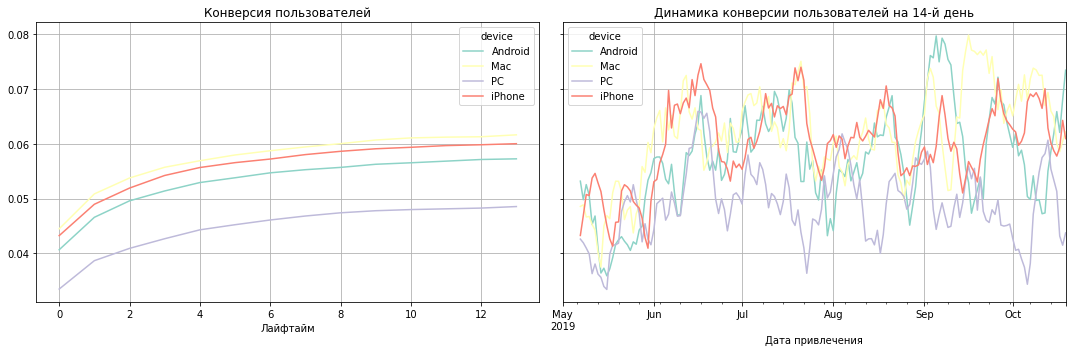

In [61]:
# Сделаем график
plot_conversion(c_device, c_device_history, horizon=14)

In [71]:
# Посчитаем rate retention, задав dimensions=['device']
r_device_raw, r_device, r_device_history = get_retention(profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

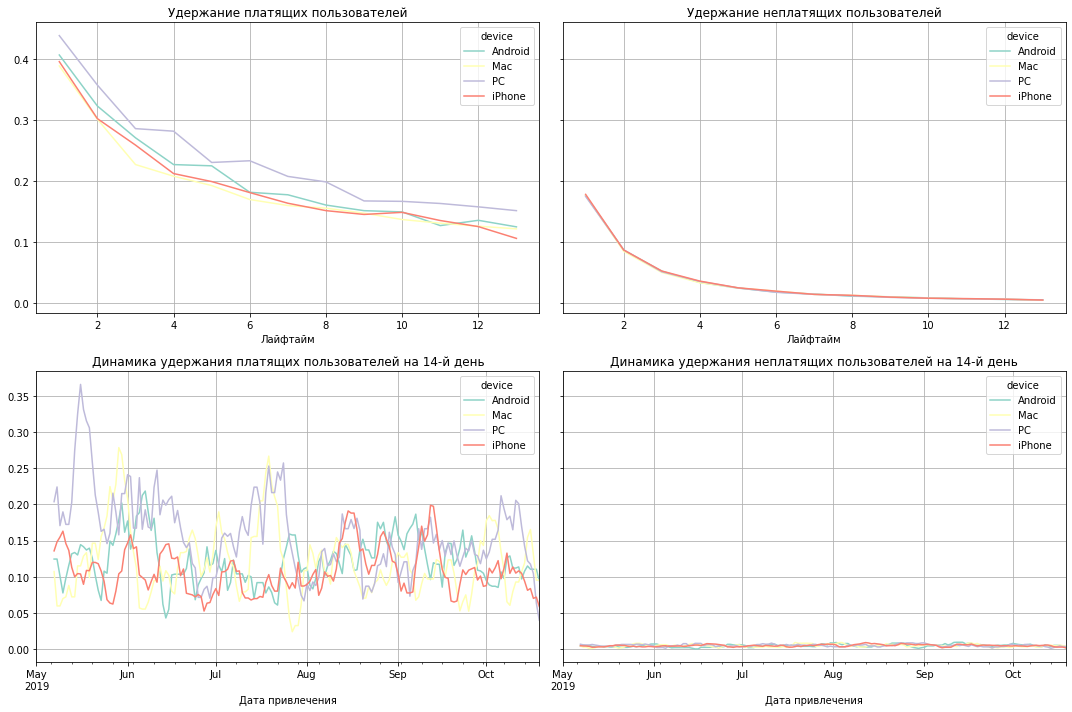

In [72]:
# Сделаем график
plot_retention(r_device, r_device_history, horizon=14)

### Конверсия и rate retention в разбивке по странам

In [62]:
# Посчитаем конверсию, задав dimensions=['region']
c_region_raw, c_region, c_region_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

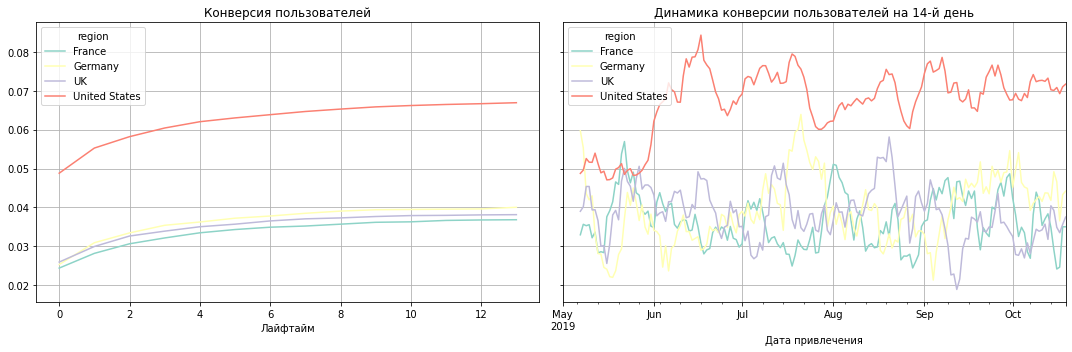

In [64]:
# Сделаем график
plot_conversion(c_region, c_region_history, horizon=14)

In [73]:
# Посчитаем rate retention, задав dimensions=['region']
r_region_raw, r_region, r_region_history = get_retention(profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

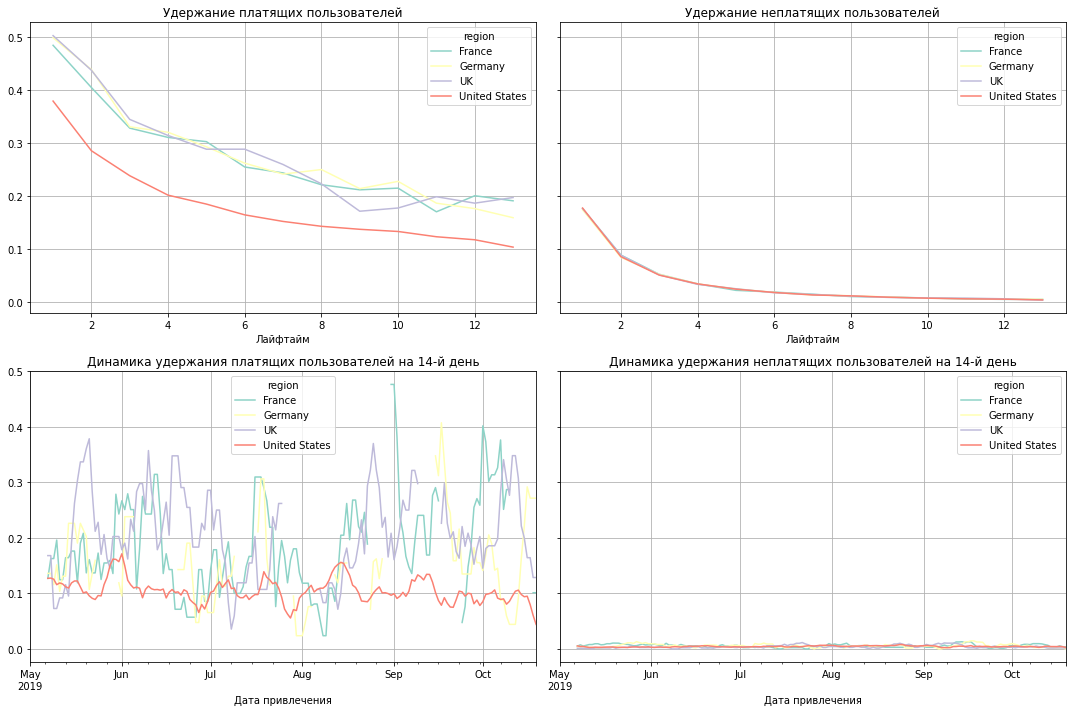

In [74]:
# Сделаем график
plot_retention(r_region, r_region_history, horizon=14)

### Конверсия и rate retention в разбивке по рекламным каналам

In [65]:
# Посчитаем конверсию, задав dimensions=['channel']
c_channel_raw, c_channel, c_channel_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

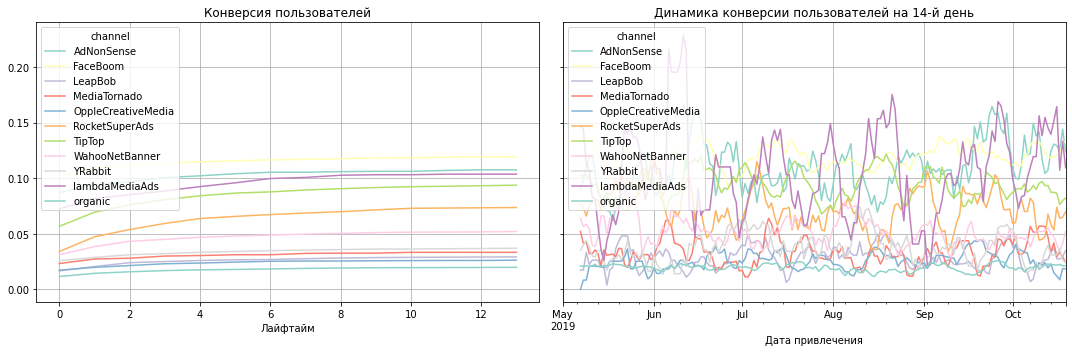

In [66]:
# Сделаем график
plot_conversion(c_channel, c_channel_history, horizon=14)

In [75]:
# Посчитаем rate retention, задав dimensions=['channel']
r_channel_raw, r_channel, r_channel_history = get_retention(profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

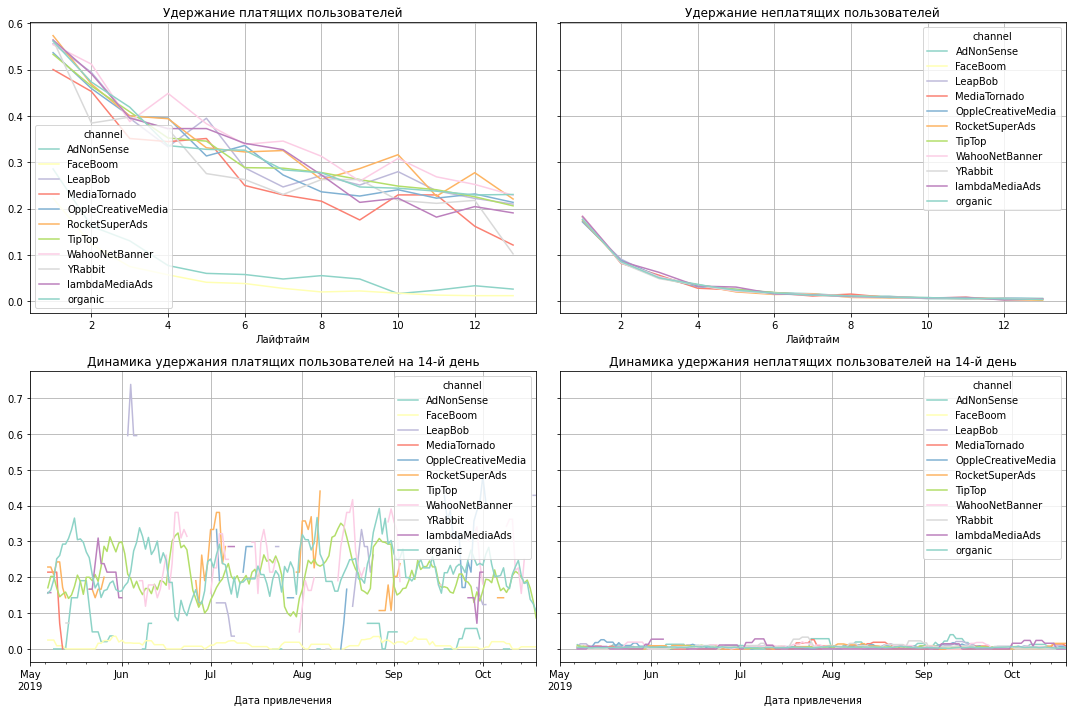

In [76]:
# Сделаем график
plot_retention(r_channel, r_channel_history, horizon=14)

In [167]:
# Дополнительно посмотрим окупаемость в разбивке по каналам в США
usa_channel_raw, usa_ltv_channel, usa_ltv_channel_hist, usa_roi_channel, usa_roi_channel_hist = get_ltv(profiles.query('region == "United States"'), orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

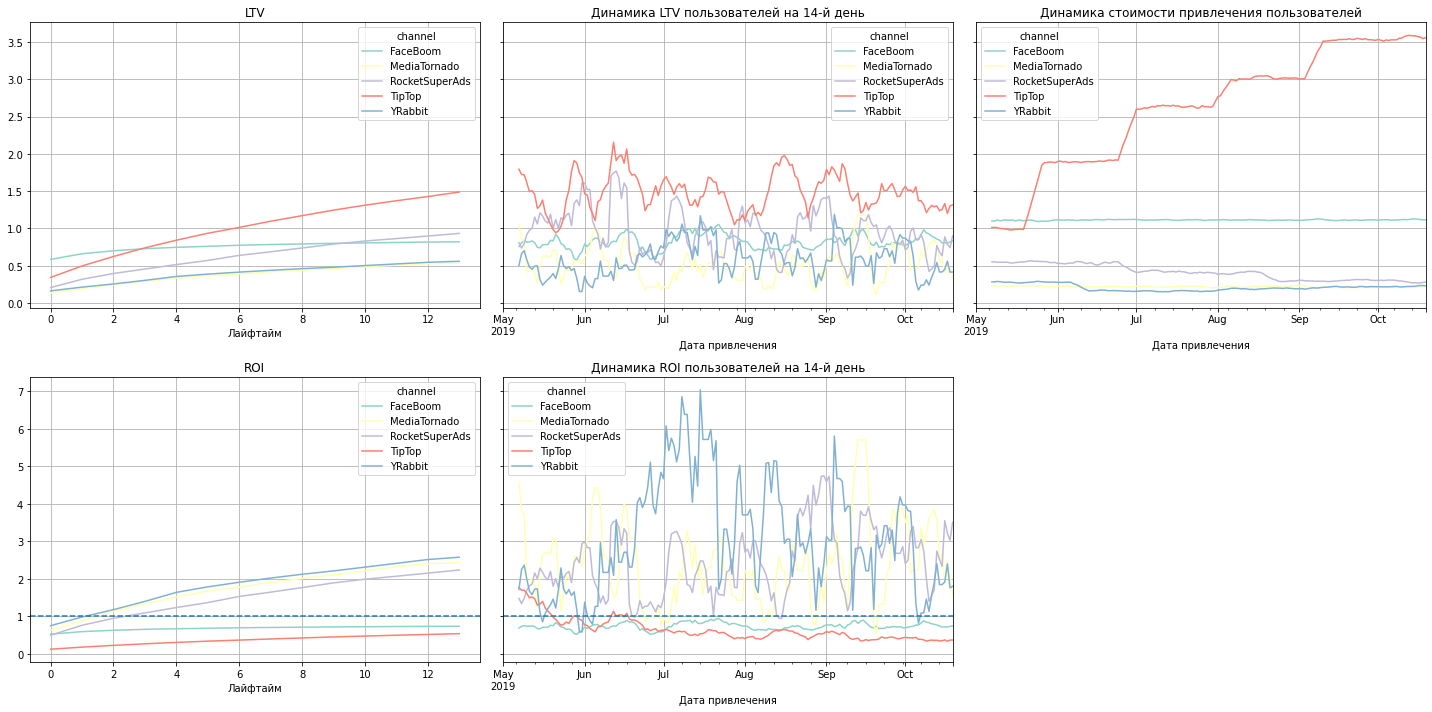

In [168]:
# Построим графики
plot_ltv_roi(usa_ltv_channel, usa_ltv_channel_hist, usa_roi_channel, usa_roi_channel_hist, 14)

### Промежуточные выводы

- В разбивке по дейвайсам проблемными категориями являются Mac и iPhone. По графикам конверсии и удержания видно, что пользователи с этими устройствами хорошо конвертируются, однако плохо удерживаются. Возможно, дело в технической ошибке или в менее удобном интерфейсе.
- В разбивке по странам проблемной страной являются США. По графикам также видно что пользователи из США отлично конвертируются, но совершенно плохо удерживаются. Возможно дело в культурных особенностях американцев или в способе оплаты не подходящем для этого континента.
- В разбивке по каналам проблемным каналом является TipTop, а также FaceBoom и AddNonSence. По графикам, у TipTop и конверсия, и удержание в порядке, вероятно, дело в том, что реклама в TipTop просто очень дорогая. Другие два канала показывают лучшую конвертируемость и худшее удержание платящих пользователей.
- Изучив окупаемость в разбивке по каналам в США, мы видим, что проблемные каналы (кроме AddNonSence) направлены в основном на американскую аудиторию и не окупаются в этом регионе, а канал TipTop каждый месяц становится более затратным. Это может быть из-за того, что увеличиваются вложения в рекламу или из-за сокращения числа привлеченных пользователей, судя по хорошему LTV дело скорее в первом варианте.

## Выводы

Таким образом, исследование прошло в 6 этапов:
1. **Обзор данных.** На этом этапе датасет был распакован и изучен на предмет пропусков, аномалий и дубликатов.

2. **Подготовка данных.** На этом этапе названия столбцов были приведены к одному виду, а типы данных были изменены на нужные.

3. **Подготовка функций.** На этом этапе были написаны основные функции для нахождения метрик и их визуализации.

4. **Исследовательский анализ данных.** На этом этапе была изучена доля платящих пользователей, по регионам, устройствам и каналам. 

5. **Маркетинговый анализ данных.** На этом этапе были посчитаны общие и частные расходы на рекламу.

6. **Оценка окупаемости рекламы.** На этом этапе были посчитаны и визуализированы основные метрики бизнес-экономики.

**Исследовательский анализ данных:** выводы
1. Больше всего платящих приходится на США (~ 6%)
2. Больше всего платящих приходится на iPhone (~ 6%)
3. Пользователи приходят из 11 источников привлечения. Топ-3 среди количества привлеченных платящих пользователей - FaceBoom (~ 12%), TipTop (~ 111%), organic (~ 10%). Стоит заметить, что органических пользователей, т.е. пришедших сами по себе, действительно много, по сравнению с другими источниками. 

**Маркетинговый анализ данных:** выводы
1. Всего было потрачено на рекламу - около 105497 ден. ед
2. Топ-3 самых дорогих источников привлечения пользователей - TipTop (54751.30), FaceBoom (32445.60), WahooNetBanner (5151.00).
3. Рост аудитории нестабилен, несмотря на увеличение трат на рекламу.
4. В среднем, один новый пользователь обошелся компании в 1,1 ден. ед.
5. Дороже всего обошлись пользователи с источников - TipTop (2.799003), FaceBoom (1.113286), AdNonSense (1.008054).

**Анализ окупаемости рекламы:** выводы
1. LTV к концу лайфтайма почти достигает 0,70.
2. Пик LTV на 14 день приходится на июнь.
3. Стоимость привлечения неуклонно растет, резкий скачок приходится на июнь.
4. Однако траты на рекламу к концу лайфтайма едва окупаются.
5. Динамика окупаемости на 14 день показывает ежемесячный спад, резкий скачок вниз также приходится на июнь.
6. Вероятно, прилив "дешевой" аудитории в первые месяцы рекламы мотивировал руководство больше вкладываться в маркетинг, однако дальнешая реклама показывала уже не такие результаты, а расходы на нее увеличивались.

**Общий вывод.**

**Причины неэффективности:** 

Возможно, изучая ситуацию с долей платящих пользователей в разных регионах, с разными устройствами и с разных каналов привлечения, менеджеры сделали вывод, что надо вкладываться в уже проверенных лидеров по продажам (США, Айфон, TipTop), однако, эти рынки могут переполниться и больше не давать новых пользователей. Именно это может показывать чрезвычайная низкая окупаемость по этим направлениям. Другой причиной может быть увеличение рекламного бюджета при том же количестве привлекаемых пользователей. Также препятствовать удержанию пользователей может техническая ошибка в разделе оплаты или в интерфейсе.

**Рекомендации:**
1. Сократить расходы на рекламу: в каналах с недостаточным ROI; в уже освоенных рынках; в каналах с недостаточным трафиком.
2. Рассмотреть вариант с вложением средств в рынки с меньшей долей платящих клиентов, таких как Великобритания и Android, однако которые можно расширить; в каналы с хорошей окупаемостью и стабильным LTV, например, LambdaMediaAds.
3. Изучить проблему плохого удержания пользователей с iPhone и Mac, возможно дело в технической ошибке.